# CS224N Assignment 1: Exploring Word Vectors (25 Points)

Welcome to CS224n! 

Before you start, make sure you read the README.txt in the same directory as this notebook. 

In [11]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Please Write Your SUNet ID Here: 

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

# Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have come into fashion, e.g. word2vec. Here, we shall explore the embeddings produced by word2vec. Please revisit the class notes and lecture slides for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Then run the following cells to load the word2vec vectors into memory.**Note**: This might take several minutes.

- Prediction-based 워드 임베딩 방식 중 하나인 word2vec을 구현한 결과를 분석해보자.

In [4]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each length 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    # 파이썬 json에서 파일을 읽을 때는 load를, 문자열을 읽을 때는 loads를 사용한다.
    
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [5]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 3000000


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please follow the Piazza instructions, as how to run remotely on Stanford Farmshare machines.**

### Reducing dimensionality of Word2Vec Word Embeddings
Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put the 3 million word2vec vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

- SVD를 이용하여 차원을 축소하는 과정

In [6]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    # list 내 sequence를 무작위로 재배열
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        # 예외처리문을 활용해서 except문에서 명시한 KeyError가 발생하더라도 continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    # numpy stack함수를 통해 배열을 합친다. (둘 이상의 배열 합칠 경우, 배열 간 shape이 동일해야 함.)
    print("Done.")
    return M, word2Ind

- numpy stack 함수
https://numpy.org/doc/stable/reference/generated/numpy.stack.html

In [12]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Question 2.1: Word2Vec Plot Analysis [written] (4 points)

Run the cell below to plot the 2D word2vec embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

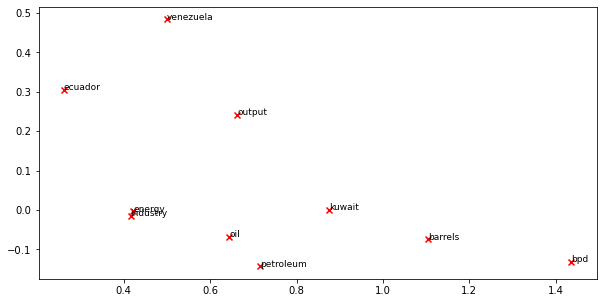

In [13]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

#### <font color="red">Write your answer here.</font>
co-occurence matrix를 바탕으로 한 embedding space보다는 단어들의 분포가 less dense하다.
energy와 industry가 붙어 있는 cluster가 관찰이 되며, oil과 petroleum은 서로 가깝게 위치하지만, barrels나 bpd 같은 oil의 단위 관련 단어와는 멀리 떨어져 있다.
산유국 관련 단어인 ecuador, venezuela, kuwait가 가깝게 위치하고, output이 barrels, bpd 근처에 위치해야 할 것 같다.

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 


- 개별 단어들 간의 유사성을 판단하기 위해 --> 두 벡터 간의 코사인 각도를 통해 구하는 cosine similarity를 측정하자.
- 두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90°의 각을 이루면 0, 180°로 반대의 방향을 가지면 -1의 값을 갖게 됩니다. 
- 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다. 

https://wikidocs.net/24603

### Question 2.2: Polysemous Words (2 points) [code + written] 
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.


- 다의어(polysemous word)가 적절하게 분석이 되었는지 결과를 확인해보자.

In [14]:
# ------------------
# Write your polysemous word exploration code here.
polysem_words = ['bank', 'man', 'leave',
                'bright', 'mouse', 'pupil',
                'chip', 'wood', 'wave']

for word in polysem_words:
    print('Top 10 most similar words to', word, ':')
    print(wv_from_bin.most_similar(word, topn=10))
    print('-'*10)
# ------------------

Top 10 most similar words to bank :
[('banks', 0.7440759539604187), ('banking', 0.690161406993866), ('Bank', 0.6698698997497559), ('lender', 0.6342284679412842), ('banker', 0.6092953681945801), ('depositors', 0.6031531691551208), ('mortgage_lender', 0.5797975659370422), ('depositor', 0.5716428160667419), ('BofA', 0.5714625120162964), ('Citibank', 0.5589520335197449)]
----------
Top 10 most similar words to man :
[('woman', 0.7664012908935547), ('boy', 0.6824870109558105), ('teenager', 0.6586930155754089), ('teenage_girl', 0.6147903800010681), ('girl', 0.5921714305877686), ('suspected_purse_snatcher', 0.5716364979743958), ('robber', 0.5585119128227234), ('Robbery_suspect', 0.5584409236907959), ('teen_ager', 0.5549196600914001), ('men', 0.5489763021469116)]
----------
Top 10 most similar words to leave :
[('leaving', 0.6598548889160156), ('stay', 0.5787086486816406), ('depart', 0.5559219121932983), ('Leaving', 0.5488994717597961), ('left', 0.525093138217926), ('leaves', 0.513140380382537

#### <font color="red">Write your answer here.</font>
(이 부분은 답변을 잘 모르겠어서 검색 결과 가장 reasonable 하다고 생각되는 답변을 가지고 왔다.
https://github.com/formiel/cs224n/blob/master/a1/exploring_word_vectors.ipynb)

The polysemous word that I discovered: wave. There are 2 meanings of the word wave that occur in its top 10 most similar words: (1) a raised line of water across a surface of river or sea (_tide, tidalwave etc.) and (2) an increase in something (surge, upswell)

Most of the words that I tried did not work (9/10). Their top 10 most similar words basically carry the same meanings as their own. I think this is possibly because the word vectors have been trained on the same field, in this case the crude oil industry. Hence, it is not very usual to use very different senses of a word in the same enviroment.

I think that if different senses of a word are all commonly used, then it is logical to get multiple meanings of a word in the top 10 most similar algorithm. But why are there some words that are used with their different meanings more often than others? My hypothesis is that for words whose their literal meanings have something inherently referring to their figurative meanings (for example tide is the literal meaning and surge is the figurative meaning of wave), it is more likely to retrieve their different meanings in the top 10 most similar words. This is only my hypothesis since I think that it normally sounds better with something that could trigger your visual imagination, hence it is more common to use different senses of such words.

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [15]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "good"
w2 = "excellent"
w3 = "bad"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms good, excellent have cosine distance: 0.3557071089744568
Antonyms good, bad have cosine distance: 0.28099489212036133


#### <font color="red">Write your answer here.</font>
반의어가 반대되는 의미를 가지고 있다고 해도, two emotional scales 상에 평행하게 놓인다.
이 two emotional scales는 happy에서 cheerful까지의 거리에 비해 더 가깝다.

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x", what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [16]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]


### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [17]:
# ------------------
# Write your analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['bad', 'excellent'], negative=['good']))

# ------------------

[('atrocious', 0.5587530732154846),
 ('abysmal', 0.5366191864013672),
 ('lousy', 0.5216928124427795),
 ('exceptional', 0.5126670002937317),
 ('dreadful', 0.5080001354217529),
 ('horrid', 0.5061171054840088),
 ('horrible', 0.4950227439403534),
 ('awful', 0.493507444858551),
 ('appalling', 0.48994988203048706),
 ('horrendous', 0.486495703458786)]


#### <font color="red">Write your answer here.</font>
The above analogy is of the form: good:excellent :: bad:atrocious.

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [18]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['text', 'mathmatics'], negative=['number']))

# ------------------

[('LaTeX', 0.5075627565383911),
 ('algebra_trigonometry', 0.5065194368362427),
 ('texts', 0.49263715744018555),
 ('mathematical_notation', 0.47823071479797363),
 ('MathML', 0.473571240901947),
 ('By_James_CREEDON', 0.47091731429100037),
 ('grammar_vocabulary', 0.46949633955955505),
 ('expository_writing', 0.46935802698135376),
 ('geometry_trigonometry', 0.4684414863586426),
 ('Koranic_interpretation', 0.4681488573551178)]


#### <font color="red">Write your answer here.</font>
The analogy is of the form: number:mathematics :: text:literature. The incorrect value of b is math.

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.

Run the cell below, to examine (a) which terms are most similar to "woman" and "boss" and most dissimilar to "man", and (b) which terms are most similar to "man" and "boss" and most dissimilar to "woman". What do you find in the top 10?

In [19]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.459408164024353),
 ('Manageress', 0.45598435401916504),
 ('receptionist', 0.4474116861820221),
 ('Jane_Danson', 0.44480547308921814),
 ('Fiz_Jennie_McAlpine', 0.44275766611099243),
 ('Coronation_Street_actress', 0.44275569915771484),
 ('supremo', 0.4409852921962738),
 ('coworker', 0.4398624897003174)]

[('supremo', 0.6097397804260254),
 ('MOTHERWELL_boss', 0.5489562153816223),
 ('CARETAKER_boss', 0.5375303626060486),
 ('Bully_Wee_boss', 0.5333974361419678),
 ('YEOVIL_Town_boss', 0.5321705341339111),
 ('head_honcho', 0.5281980037689209),
 ('manager_Stan_Ternent', 0.525971531867981),
 ('Viv_Busby', 0.5256163477897644),
 ('striker_Gabby_Agbonlahor', 0.5250812768936157),
 ('BARNSLEY_boss', 0.5238943099975586)]


#### <font color="red">Write your answer here.</font>
man:boss :: woman:u: u are bosses, manageress, exec, Manegeress and the 5th, 6th and 7th result refer to receptionist and actresses.
woman:boss :: man:v: all refer to different types of managers except for only the 9th result, which refers to a striker in football.

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (2 points)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [20]:
# ------------------
# Write your bias exploration code here.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'computer_programmer'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'computer_programmer'], negative=['woman']))
print('-' * 60)
pprint.pprint(wv_from_bin.most_similar(positive=['mother', 'doctor'], negative=['father']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['father', 'doctor'], negative=['mother']))

# ------------------

[('homemaker', 0.5627118945121765),
 ('housewife', 0.5105047225952148),
 ('graphic_designer', 0.505180299282074),
 ('schoolteacher', 0.49794942140579224),
 ('businesswoman', 0.49348920583724976),
 ('paralegal', 0.4925510883331299),
 ('registered_nurse', 0.49079740047454834),
 ('saleswoman', 0.4881627559661865),
 ('electrical_engineer', 0.4797726571559906),
 ('mechanical_engineer', 0.4755399823188782)]

[('mechanical_engineer', 0.5722424387931824),
 ('programmer', 0.5207855105400085),
 ('electrical_engineer', 0.5194995403289795),
 ('carpenter', 0.5049606561660767),
 ('engineer', 0.5011439919471741),
 ('machinist', 0.4978950619697571),
 ('salesman', 0.4879138171672821),
 ('tinkerer', 0.4761508107185364),
 ('mechanic', 0.47450771927833557),
 ('mathematician', 0.4683227837085724)]
------------------------------------------------------------
[('nurse', 0.7127889394760132),
 ('doctors', 0.6593285799026489),
 ('gynecologist', 0.6454397439956665),
 ('physician', 0.6408007740974426),
 ('nurse_p

#### <font color="red">Write your answer here.</font>
남성-컴퓨터 프로그래머 거리가 여성-가정주부까지의 거리와 동일한 성 편향을 나타낸다. 아버지-의사 거리는 어머니-간호사 거리와 같다. 
사회적인 고정관념이나 편견이 이러한 단어 벡터를 입력으로 사용하는 모델의 결과에 영향을 미칠 수 있다.

### Question 2.8: Thinking About Bias [written] (1 point)

What might be the cause of these biases in the word vectors?

#### <font color="red">Write your answer here.</font>
성별과 직업 간의 관계를 담고 있는 word vetors가 이러한 편견을 만들 수도 있다.

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your SUNET ID above.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells). 
4. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
7. Submit your PDF on Gradescope.